In [1]:
from __future__ import division, print_function, unicode_literals

import numpy as np
import os

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

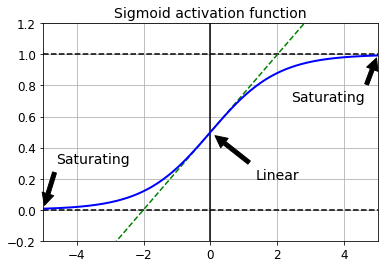

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5,5], [0,0], 'k--')
plt.plot([-5,5], [1,1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z , logit(z), "b-", linewidth=2)
props = dict(facecolor='black',shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops= props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,fontsize=14, ha="center")
plt.annotate('Linear',xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

In [4]:
import tensorflow as tf

In [5]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init,name="hidden1")

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha * z, z)

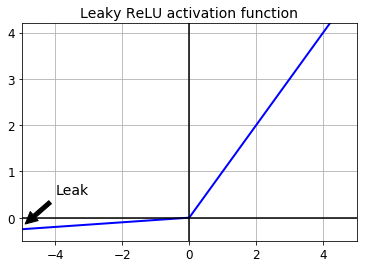

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0,0], 'k-')
plt.plot([0, 0], [-.5, 4.2],'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

In [11]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [12]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [13]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [14]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [15]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [16]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [18]:
(X_train, y_train),(X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28 * 28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28 * 28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [19]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [20]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y:y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y:y_valid})
            print(epoch,"Batch accuracy:", acc_batch,"Validation accuracy", acc_valid)
            
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy 0.9044
5 Batch accuracy: 0.94 Validation accuracy 0.9494
10 Batch accuracy: 0.92 Validation accuracy 0.9652
15 Batch accuracy: 0.94 Validation accuracy 0.971
20 Batch accuracy: 1.0 Validation accuracy 0.976
25 Batch accuracy: 1.0 Validation accuracy 0.9778
30 Batch accuracy: 0.98 Validation accuracy 0.978
35 Batch accuracy: 1.0 Validation accuracy 0.9786


In [21]:
def elu(z, alpha= 1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

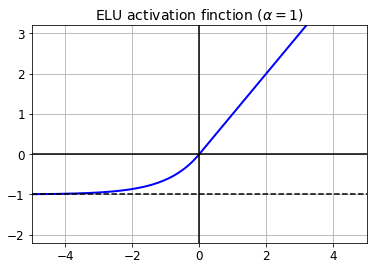

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1,-1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation finction ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [23]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [24]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

In [25]:
from scipy.special import erfc

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc( 1/ np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))** 2 * np.e - 2*(2+np.pi)* erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [26]:
def selu(z, scale=scale_0_1,alpha=alpha_0_1):
    return scale * elu(z, alpha)

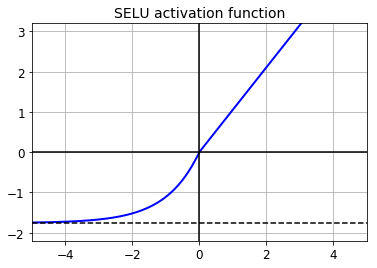

In [27]:
plt.plot(z, selu(z),"b-",linewidth=2)
plt.plot([-5, 5], [0, 0],'k-')
plt.plot([-5,5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function",fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [28]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(1000):
    W = np.random.normal(size=(100,100), scale=np.sqrt(1 / 100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean{:.2f}, std deviation {:.2f}".format(layer,means,stds))

Layer 0: mean-0.00, std deviation 1.00
Layer 100: mean0.02, std deviation 0.96
Layer 200: mean0.01, std deviation 0.90
Layer 300: mean-0.02, std deviation 0.92
Layer 400: mean0.05, std deviation 0.89
Layer 500: mean0.01, std deviation 0.93
Layer 600: mean0.02, std deviation 0.92
Layer 700: mean-0.02, std deviation 0.90
Layer 800: mean0.05, std deviation 0.83
Layer 900: mean0.02, std deviation 1.00


In [29]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
outputs = 10

X = tf.placeholder(tf.float32,shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1,activation=tf.nn.selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

In [30]:
means = X_train.mean(axis = 0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
        
        
    save_path = saver.save(sess, "./my_model_selu.ckpt")

0 Batch accuracy: 0.92 Validation accuracy: 0.9194
5 Batch accuracy: 0.96 Validation accuracy: 0.9546
10 Batch accuracy: 0.98 Validation accuracy: 0.9638
15 Batch accuracy: 0.96 Validation accuracy: 0.9676
20 Batch accuracy: 1.0 Validation accuracy: 0.968
25 Batch accuracy: 1.0 Validation accuracy: 0.9684
30 Batch accuracy: 1.0 Validation accuracy: 0.9714
35 Batch accuracy: 1.0 Validation accuracy: 0.9716


In [31]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)

In [32]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

In [33]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [34]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()
    
    my_batch_norm_layer = partial(
        tf.layers.batch_normalization,
        training = training,
        momentum = batch_norm_momentum)
    
    my_dense_layer = partial(
        tf.layers.dense,
        kernel_initializer=he_init)
    
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer= tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [35]:
n_epochs = 20 
batch_size = 200

In [36]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                    feed_dict={training:True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy: ", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy:  0.8952
1 Validation accuracy:  0.9202
2 Validation accuracy:  0.9318
3 Validation accuracy:  0.9422
4 Validation accuracy:  0.9468
5 Validation accuracy:  0.954
6 Validation accuracy:  0.9568
7 Validation accuracy:  0.96
8 Validation accuracy:  0.962
9 Validation accuracy:  0.9638
10 Validation accuracy:  0.9662
11 Validation accuracy:  0.9682
12 Validation accuracy:  0.9672
13 Validation accuracy:  0.9696
14 Validation accuracy:  0.9706
15 Validation accuracy:  0.9704
16 Validation accuracy:  0.9718
17 Validation accuracy:  0.9726
18 Validation accuracy:  0.9738
19 Validation accuracy:  0.9742


In [37]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name = "X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name ="hidden1")
    hidden2 = tf.layers.dense(hidden1,n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2,n_hidden3, activation=tf.nn.relu,name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu,name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [38]:
learning_rate = 0.01

In [39]:
threshold = 1.0 

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold,threshold), var)
             for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [40]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [41]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [42]:
n_epochs = 20
batch_size=200

In [43]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.7942
2 Validation accuracy: 0.8798
3 Validation accuracy: 0.9062
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9218
6 Validation accuracy: 0.929
7 Validation accuracy: 0.9356
8 Validation accuracy: 0.9382
9 Validation accuracy: 0.9416
10 Validation accuracy: 0.946
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9534
14 Validation accuracy: 0.9566
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.9588
18 Validation accuracy: 0.9624
19 Validation accuracy: 0.9614


In [44]:
reset_graph()

In [45]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

In [46]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [47]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [48]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [49]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

In [50]:
with tf.Session() as sess:
    saver.restore(sess,"./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y:y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess,"./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9642
1 Validation accuracy: 0.963
2 Validation accuracy: 0.9652
3 Validation accuracy: 0.965
4 Validation accuracy: 0.964
5 Validation accuracy: 0.9648
6 Validation accuracy: 0.969
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.968
9 Validation accuracy: 0.969
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9712
12 Validation accuracy: 0.9666
13 Validation accuracy: 0.9698
14 Validation accuracy: 0.971
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.9716
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9714
19 Validation accuracy: 0.971


In [51]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()

In [52]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y:y_valid})
        print(epoch, "Validation accuracy", accuracy_val)
        
    save_path = saver.save(sess,"./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy 0.9642
1 Validation accuracy 0.963
2 Validation accuracy 0.9652
3 Validation accuracy 0.965
4 Validation accuracy 0.964
5 Validation accuracy 0.9648
6 Validation accuracy 0.969
7 Validation accuracy 0.9686
8 Validation accuracy 0.968
9 Validation accuracy 0.969
10 Validation accuracy 0.9704
11 Validation accuracy 0.9712
12 Validation accuracy 0.9666
13 Validation accuracy 0.9698
14 Validation accuracy 0.971
15 Validation accuracy 0.9724
16 Validation accuracy 0.9716
17 Validation accuracy 0.9712
18 Validation accuracy 0.9714
19 Validation accuracy 0.971


In [53]:
reset_graph()

n_hidden4 = 20
n_hidden5 = 10

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [54]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = new_saver.save(sess,"./my_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9116
1 Validation accuracy: 0.938
2 Validation accuracy: 0.946
3 Validation accuracy: 0.9502
4 Validation accuracy: 0.9528
5 Validation accuracy: 0.9524
6 Validation accuracy: 0.9566
7 Validation accuracy: 0.9598
8 Validation accuracy: 0.9614
9 Validation accuracy: 0.961
10 Validation accuracy: 0.9634
11 Validation accuracy: 0.9626
12 Validation accuracy: 0.9648
13 Validation accuracy: 0.9654
14 Validation accuracy: 0.9662
15 Validation accuracy: 0.9674
16 Validation accuracy: 0.9678
17 Validation accuracy: 0.9678
18 Validation accuracy: 0.9684
19 Validation accuracy: 0.9678


In [55]:
reset_graph()

n_inputs = 28 * 28 
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 20
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs),name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"): 
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [56]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]")

restore_saver = tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch,y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9414
1 Validation accuracy: 0.9554
2 Validation accuracy: 0.9608
3 Validation accuracy: 0.9628
4 Validation accuracy: 0.9638
5 Validation accuracy: 0.9646
6 Validation accuracy: 0.9666
7 Validation accuracy: 0.9668
8 Validation accuracy: 0.9686
9 Validation accuracy: 0.969
10 Validation accuracy: 0.9698
11 Validation accuracy: 0.9704
12 Validation accuracy: 0.9698
13 Validation accuracy: 0.9702
14 Validation accuracy: 0.9712
15 Validation accuracy: 0.971
16 Validation accuracy: 0.9716
17 Validation accuracy: 0.9724
18 Validation accuracy: 0.9716
19 Validation accuracy: 0.9726


In [57]:
reset_graph()

n_inputs  = 2
n_hidden1 = 3

In [58]:
original_w = [[1., 2., 3.],[4., 5., 6.]]
original_b = [7., 8., 9.]

X = tf.placeholder(tf.float32,shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")

graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


In [59]:
reset_graph()

n_inputs = 2 
n_hidden1 = 3

original_w = [[1., 2., 3.],[4., 5., 6.]]
original_b = [7., 8., 9.]

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")

with tf.variable_scope("", default_name="", reuse=True):
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")
    
original_weights = tf.placeholder(tf.float32,shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


In [60]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

In [61]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [62]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

In [63]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 20
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy,name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [64]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [65]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="hidden[123]")

restore_saver = tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y:y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9668
1 Validation accuracy: 0.9704
2 Validation accuracy: 0.9702
3 Validation accuracy: 0.9712
4 Validation accuracy: 0.9718
5 Validation accuracy: 0.9718
6 Validation accuracy: 0.973
7 Validation accuracy: 0.9736
8 Validation accuracy: 0.9738
9 Validation accuracy: 0.9738
10 Validation accuracy: 0.9738
11 Validation accuracy: 0.9738
12 Validation accuracy: 0.9724
13 Validation accuracy: 0.9734
14 Validation accuracy: 0.9744
15 Validation accuracy: 0.972
16 Validation accuracy: 0.9734
17 Validation accuracy: 0.9738
18 Validation accuracy: 0.9734
19 Validation accuracy: 0.9734


In [66]:
reset_graph()

n_inputs = 28 * 28 
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50 
n_hidden4 = 20
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs),name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [67]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")

In [68]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [69]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]")
restore_saver= tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess,"./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y:y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9548
1 Validation accuracy: 0.961
2 Validation accuracy: 0.9638
3 Validation accuracy: 0.9662
4 Validation accuracy: 0.9668
5 Validation accuracy: 0.9692
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9704
8 Validation accuracy: 0.9704
9 Validation accuracy: 0.9714
10 Validation accuracy: 0.972
11 Validation accuracy: 0.971
12 Validation accuracy: 0.9714
13 Validation accuracy: 0.9708
14 Validation accuracy: 0.9718
15 Validation accuracy: 0.9712
16 Validation accuracy: 0.9708
17 Validation accuracy: 0.9722
18 Validation accuracy: 0.9722
19 Validation accuracy: 0.9712


In [70]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=.9)

In [71]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9,use_nesterov=True)

In [72]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

In [73]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.9, decay=0.9, epsilon=1e-10)

In [74]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [75]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [76]:
with tf.name_scope("train"):       
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [77]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [78]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9624
1 Validation accuracy: 0.9736
2 Validation accuracy: 0.973
3 Validation accuracy: 0.9798
4 Validation accuracy: 0.9808


In [79]:
reset_graph()

n_inputs = 28 * 28 
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")


In [80]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    base_los = tf.reduce_mean(xentropy,name="avg_xentropy")
    reg_loss= tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_los, scale * reg_loss,name="loss")

In [81]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name="accuracy")
    
learning_rate = 0.01
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [82]:
n_epochs = 20 
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy: ", accuracy_val)
        
    save_path = saver.save(sess,"./my_model_final.ckpt")

0 Validation accuracy:  0.831
1 Validation accuracy:  0.871
2 Validation accuracy:  0.8838
3 Validation accuracy:  0.8934
4 Validation accuracy:  0.8966
5 Validation accuracy:  0.8988
6 Validation accuracy:  0.9016
7 Validation accuracy:  0.9044
8 Validation accuracy:  0.9058
9 Validation accuracy:  0.906
10 Validation accuracy:  0.9068
11 Validation accuracy:  0.9054
12 Validation accuracy:  0.907
13 Validation accuracy:  0.9084
14 Validation accuracy:  0.9088
15 Validation accuracy:  0.9064
16 Validation accuracy:  0.9066
17 Validation accuracy:  0.9066
18 Validation accuracy:  0.9066
19 Validation accuracy:  0.9052


In [83]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [84]:
scale = 0.001

In [85]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None, name="outputs")

In [86]:


with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  
        labels=y, logits=logits)                                
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

In [87]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="sccuracy")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [88]:
n_epochs = 20
batch_size = 200 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train,y_train, batch_size):
            sess.run(training_op,feed_dict={X: X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:",accuracy_val)
        
    save_path = saver.save(sess,"./my_model_final.ckpt")

0 Validation accuracy: 0.8274
1 Validation accuracy: 0.8766
2 Validation accuracy: 0.8952
3 Validation accuracy: 0.9016
4 Validation accuracy: 0.9084
5 Validation accuracy: 0.9096
6 Validation accuracy: 0.9124
7 Validation accuracy: 0.9154
8 Validation accuracy: 0.9178
9 Validation accuracy: 0.919
10 Validation accuracy: 0.92
11 Validation accuracy: 0.9224
12 Validation accuracy: 0.9212
13 Validation accuracy: 0.9228
14 Validation accuracy: 0.9224
15 Validation accuracy: 0.9216
16 Validation accuracy: 0.9218
17 Validation accuracy: 0.9228
18 Validation accuracy: 0.9216
19 Validation accuracy: 0.9214


In [89]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [90]:


training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5 
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [91]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
    with tf.name_scope("train"):
        optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
        training_op = optimizer.minimize(loss)
        
    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [92]:
n_epochs = 20 
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch,y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch,training:True})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y: y_valid})
        print(epoch, "Validation accuracy", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy 0.9254
1 Validation accuracy 0.9452
2 Validation accuracy 0.9476
3 Validation accuracy 0.9566
4 Validation accuracy 0.9584
5 Validation accuracy 0.9596
6 Validation accuracy 0.9596
7 Validation accuracy 0.9666
8 Validation accuracy 0.9678
9 Validation accuracy 0.9694
10 Validation accuracy 0.969
11 Validation accuracy 0.9684
12 Validation accuracy 0.9716
13 Validation accuracy 0.97
14 Validation accuracy 0.9714
15 Validation accuracy 0.9716
16 Validation accuracy 0.972
17 Validation accuracy 0.9722
18 Validation accuracy 0.9734
19 Validation accuracy 0.974


In [93]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50 
n_outputs = 10 

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs),name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hodden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    

In [95]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clipped_weights = tf.assign(weights, clipped_weights)

In [96]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

In [97]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [98]:
n_epochs = 20 
batch_size = 50

In [99]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
            clipped_weights.eval()
            clip_weights2.eval()
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", acc_valid)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy 0.9566
1 Validation accuracy 0.9706
2 Validation accuracy 0.9718
3 Validation accuracy 0.977
4 Validation accuracy 0.9762
5 Validation accuracy 0.9774
6 Validation accuracy 0.9814
7 Validation accuracy 0.9818
8 Validation accuracy 0.9796
9 Validation accuracy 0.982
10 Validation accuracy 0.9826
11 Validation accuracy 0.9836
12 Validation accuracy 0.9824
13 Validation accuracy 0.9836
14 Validation accuracy 0.9844
15 Validation accuracy 0.9838
16 Validation accuracy 0.9836
17 Validation accuracy 0.9836
18 Validation accuracy 0.9842
19 Validation accuracy 0.9852


In [105]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

In [106]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [107]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [109]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [110]:
n_epochs = 20 
batch_size = 50

In [111]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy 0.974
1 Validation accuracy 0.974
2 Validation accuracy 0.974
3 Validation accuracy 0.974
4 Validation accuracy 0.974
5 Validation accuracy 0.974
6 Validation accuracy 0.974
7 Validation accuracy 0.974
8 Validation accuracy 0.974
9 Validation accuracy 0.974
10 Validation accuracy 0.974
11 Validation accuracy 0.974
12 Validation accuracy 0.974
13 Validation accuracy 0.974
14 Validation accuracy 0.974
15 Validation accuracy 0.974
16 Validation accuracy 0.974
17 Validation accuracy 0.974
18 Validation accuracy 0.974
19 Validation accuracy 0.974
